# Installation

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-9iy603ac
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-9iy603ac
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=03b210a975e9174da94a5db8d51ec6ba38cf178962a30582482799a95b1ea169
  Stored in directory: /tmp/pip-ephem-wheel-cache-vburgonx/wheels/54/34/7f/b2b4efb59db0271239ccc6450d45591df6c415c7748d1b7650
Successfully built segmentation_models


In [ ]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from keras.utils import normalize
from keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


In [ ]:
from keras.utils import custom_object_scope, get_custom_objects
import types

# ✅ Patch the missing function properly
keras.utils.generic_utils = types.SimpleNamespace(get_custom_objects=get_custom_objects)


# Now safely import segmentation_models
import segmentation_models as sm

sm.set_framework('tf.keras')
sm.framework()
print("✅ Segmentation Models ready!")


✅ Segmentation Models ready!


In [ ]:
!pip install rasterio albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 103.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Data Preparation

In [ ]:
import os
import numpy as np
import rasterio
from glob import glob
from tqdm import tqdm

image_folder = '/content/gdrive/MyDrive/DGT_Project/3.S2_timeseries/training_image'
mask_folder = '/content/gdrive/MyDrive/DGT_Project/3.S2_timeseries/training_mask'

image_files = sorted(glob(os.path.join(image_folder, '*.tif')))
mask_files = sorted(glob(os.path.join(mask_folder, '*.tif')))

assert len(image_files) == len(mask_files), "Mismatch in number of images and masks!"

images = []
masks = []
filenames = []  # To track filenames

for img_path, msk_path in tqdm(zip(image_files, mask_files), total=len(image_files)):
    with rasterio.open(img_path) as img_src:
        img = img_src.read().astype(np.float32)
        img = np.transpose(img, (1, 2, 0))
        img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
        img = img / 10000.0

    with rasterio.open(msk_path) as msk_src:
        msk = msk_src.read(1).astype(np.uint8)
        msk = np.expand_dims(msk, axis=-1)

    images.append(img)
    masks.append(msk)
    filenames.append(img_path)  # Track original image path

images = np.array(images)
masks = np.array(masks)
filenames = np.array(filenames)

print("✅ Loaded images and masks")


100%|██████████| 108/108 [00:08<00:00, 12.39it/s]


✅ Loaded images and masks


In [ ]:
images.shape

(108, 256, 256, 12)

In [ ]:
masks.shape

(108, 256, 256, 1)

# Data split and numpy conversion

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import numpy as np

# Split dataset
X_train, X_test, y_train, y_test, f_train, f_test = train_test_split(
    images, masks, filenames, test_size=0.2, random_state=0
)


# Augmentation

In [ ]:
import albumentations as A
import numpy as np

# Define each transform separately (with p=1.0 so it always applies)
transformations = [
    A.HorizontalFlip(p=1.0),
    A.VerticalFlip(p=1.0),
    A.RandomRotate90(p=1.0),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.0, 0.05), rotate=(-30, 30), p=1.0),
    A.RandomBrightnessContrast(p=1.0)
]

# Apply each transform once to every training image
def augment_training_set(x_train, y_train):
    x_aug = []
    y_aug = []

    for i in range(len(x_train)):
        # Original
        x_aug.append(x_train[i])
        y_aug.append(y_train[i])

        # Apply each transform once
        for tf in transformations:
            augmented = tf(image=x_train[i], mask=y_train[i])
            x_aug.append(augmented['image'])
            y_aug.append(augmented['mask'])

    return np.array(x_aug), np.array(y_aug)


In [ ]:
# ✅ 1. Apply augmentation to training data
X_train_aug, y_train_aug = augment_training_set(X_train, y_train)
# ✅ 2. Save augmented training set and original test set
np.save('train_xx.npy', X_train_aug)  # 7 original + 70 augmented = 77 samples
np.save('train_yy.npy', y_train_aug)

np.save('test_xx.npy', X_test)        # untouched
np.save('test_yy.npy', y_test)
np.save('test_filenames.npy', f_test)

# ✅ 3. Load saved arrays
x_train = np.load('train_xx.npy').astype('float32')
y_train = np.load('train_yy.npy').astype('float32')
x_test = np.load('test_xx.npy').astype('float32')
y_test = np.load('test_yy.npy').astype('float32')
test_filenames = np.load('test_filenames.npy')

# ✅ 4. Confirm shapes
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("test_filenames:", len(test_filenames))

x_train shape: (516, 256, 256, 12)
y_train shape: (516, 256, 256, 1)
x_test shape: (22, 256, 256, 12)
y_test shape: (22, 256, 256, 1)
test_filenames: 22


# Model

In [ ]:
n_classes = 1
activation = 'sigmoid'

# Learning rate and optimizer
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Binary segmentation loss functions
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Binary segmentation metrics
metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5),
    'accuracy'
]


In [ ]:
# Step 2: Preprocessing
# ------------------------------------
BACKBONE = 'resnet34'

# Build model
model = sm.Unet(
    backbone_name='resnet34',
    encoder_weights=None,         # ❗ disables imagenet weights
    input_shape=(256, 256, 12),   # ❗ explicitly allow 12 channels
    classes=1,
    activation='sigmoid'
)

# Compile
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │         36 │ data[0][0]        │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_170  │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │     37,632 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_171  │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_172  │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │     36,864 │ zero_padding2d_1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_173  │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel

 Total params: 24,484,405 (93.40 MB)

 Trainable params: 24,467,037 (93.33 MB)

 Non-trainable params: 17,368 (67.84 KB)

In [ ]:
history = model.fit(
    x_train, y_train,
    batch_size=1,
    epochs=100,
    verbose=1,
    validation_data=(x_test, y_test)
)

Epoch 1/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - accuracy: 0.9196 - f1-score: 0.4652 - iou_score: 0.3730 - loss: 0.7135 - val_accuracy: 0.8909 - val_f1-score: 0.0910 - val_iou_score: 0.0910 - val_loss: 1.3255
Epoch 2/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9628 - f1-score: 0.7257 - iou_score: 0.6257 - loss: 0.4118 - val_accuracy: 0.8909 - val_f1-score: 0.0909 - val_iou_score: 0.0909 - val_loss: 1.4389
Epoch 3/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9724 - f1-score: 0.8081 - iou_score: 0.7258 - loss: 0.2989 - val_accuracy: 0.8909 - val_f1-score: 0.0909 - val_iou_score: 0.0909 - val_loss: 1.4389
Epoch 4/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9793 - f1-score: 0.8559 - iou_score: 0.7870 - loss: 0.2529 - val_accuracy: 0.8909 - val_f1-score: 0.0909 - val_iou_score: 0.0909 - val_loss: 1.4324
Epoch 5/100
946/946 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9815 - f1-score: 0.8567 - iou_score: 0.7897 - loss: 0.2526 - va

# Accuracy

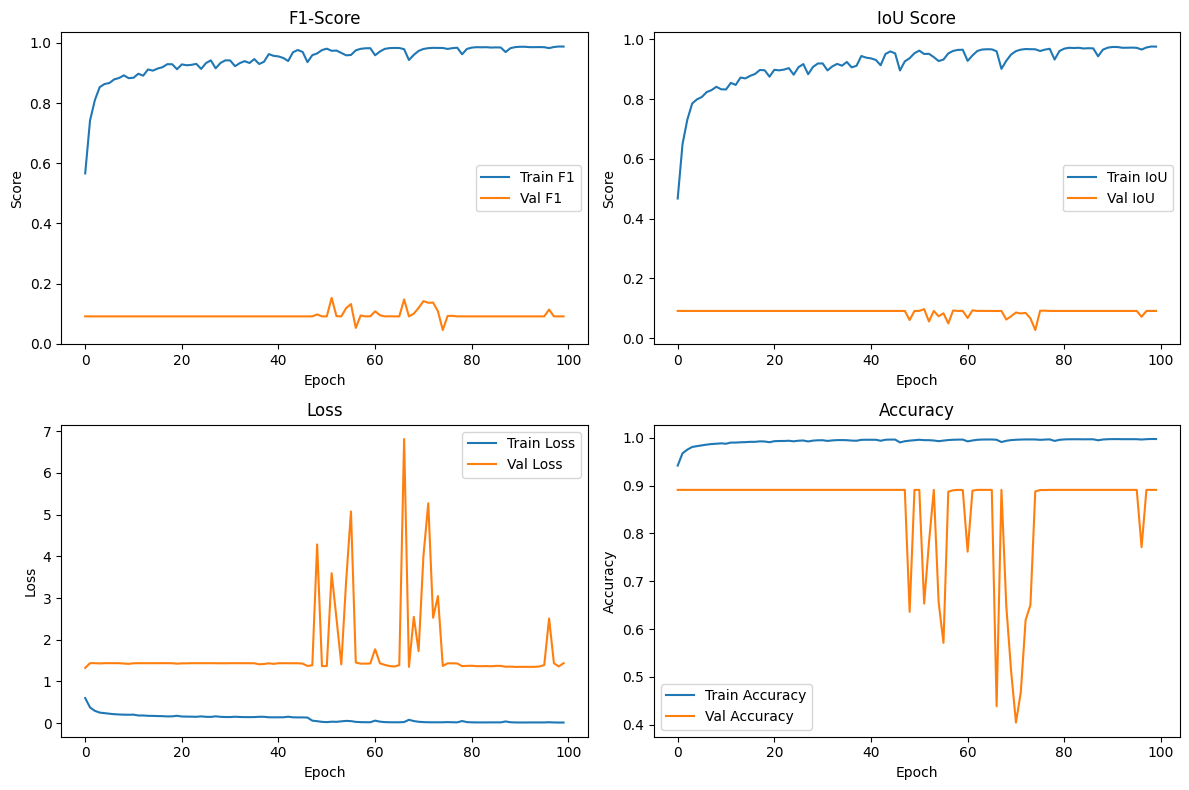

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from history
f1 = history.history['f1-score']
val_f1 = history.history['val_f1-score']
iou = history.history['iou_score']
val_iou = history.history['val_iou_score']
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot metrics
plt.figure(figsize=(12, 8))

# F1-Score
plt.subplot(2, 2, 1)
plt.plot(f1, label='Train F1')
plt.plot(val_f1, label='Val F1')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# IoU
plt.subplot(2, 2, 2)
plt.plot(iou, label='Train IoU')
plt.plot(val_iou, label='Val IoU')
plt.title('IoU Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# Loss
plt.subplot(2, 2, 3)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 2, 4)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Prediction and saving on drive

In [ ]:
# Predict
pred_test = model.predict(x_test)

# Apply threshold to get binary mask
pred_test_bin = (pred_test > 0.5).astype(np.uint8)

print(pred_test_bin.shape)  # should be (2, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
(22, 256, 256, 1)


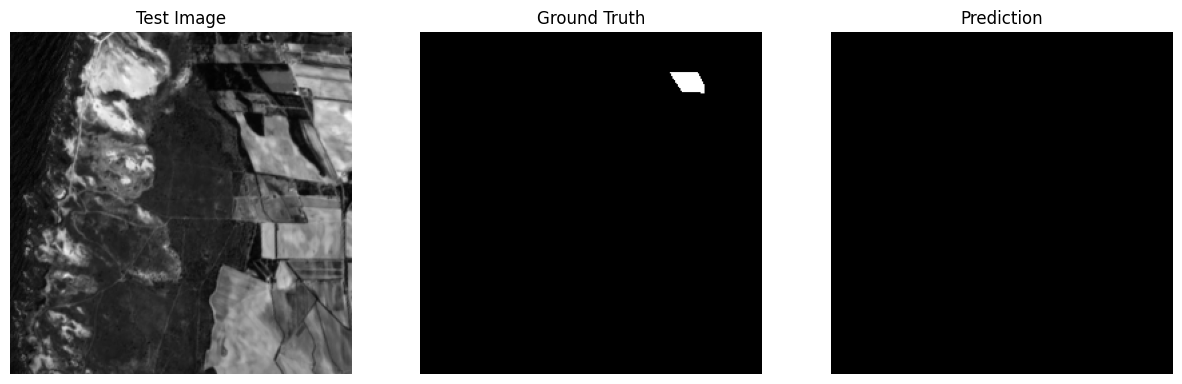

In [ ]:
import matplotlib.pyplot as plt

# Plot first test image, ground truth, and predicted mask
i = 0  # index of the test sample to view

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Test Image")
plt.imshow(x_test[i][:, :, 2], cmap='gray')  # e.g., show Band 3
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_test[i].squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred_test_bin[i].squeeze(), cmap='gray')
plt.axis('off')

plt.show()


In [ ]:
import numpy as np

# Ensure predicted and true masks are binary (0 or 1)
# y_pred: raw model predictions (e.g., probabilities)
# y_test: ground truth masks (0s and 1s)
y_pred = model.predict(x_test)
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)
y_true = y_test.astype(np.uint8)

# Flatten to 1D arrays for easier computation
y_pred_flat = y_pred_thresholded.flatten()
y_true_flat = y_true.flatten()

# Define function to calculate IoU for a given class
def calculate_class_iou(y_true, y_pred, class_val):
    intersection = np.logical_and(y_true == class_val, y_pred == class_val).sum()
    union = np.logical_or(y_true == class_val, y_pred == class_val).sum()
    return intersection / union if union != 0 else 0

# Calculate IoU for class 0 and class 1
iou_class_0 = calculate_class_iou(y_true_flat, y_pred_flat, class_val=0)
iou_class_1 = calculate_class_iou(y_true_flat, y_pred_flat, class_val=1)

print(f"IoU for Class 0 (Background): {iou_class_0:.4f}")
print(f"IoU for Class 1 (Greenhouse): {iou_class_1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
IoU for Class 0 (Background): 0.7681
IoU for Class 1 (Greenhouse): 0.0523


In [ ]:
import rasterio

pred_test_bin = (model.predict(x_test) > 0.5).astype(np.uint8)
output_dir = '/content/gdrive/MyDrive/DGT_Project/1.S2_mean/Predicted_mask_resnet_aug'
os.makedirs(output_dir, exist_ok=True)

for idx, (pred, ref_path) in enumerate(zip(pred_test_bin, test_filenames)):
    pred_mask = pred.squeeze().astype(np.uint8)

    with rasterio.open(ref_path) as ref:
        meta = ref.meta.copy()

    meta.update({
        'dtype': 'uint8',
        'count': 1,
        'nodata': 0
    })

    filename = os.path.basename(ref_path).replace("image", "pred")  # customize as needed
    out_path = os.path.join(output_dir, filename)

    with rasterio.open(out_path, 'w', **meta) as dst:
        dst.write(pred_mask[np.newaxis, :, :])

print("✅ Predictions saved with correct spatial referencing.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
✅ Predictions saved with correct spatial referencing.


In [ ]:
model.save('/content/gdrive/MyDrive/DGT_Project/1.S2_mean/unet_resnet34_aug.keras')